In [1]:
#Import Libraries
import io
import math 
import os
import pathlib
from glob import glob

import earthpy as et
import earthpy.appeears as etapp
import earthpy.earthexplorer as etee
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
from shapely.geometry import box
from xrspatial import aspect
from xrspatial import slope

In [2]:
# Create data directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final')
if not os.path.exists(data_dir):
        os.makedirs(data_dir)

# Make data directory the working directory
os.chdir(data_dir)

# Define utm zone
utm = 32613

In [3]:
# Code adapted from: https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
# Create directory
grassland_url = ('https://data.fs.usda.gov/geodata/edw/'
                 'edw_resources/shp/S_USA.NationalGrassland.zip'
)
print('Downloading shapefile...')

# Request data from url
grassland_request = requests.get(grassland_url)
grassland_zip = zipfile.ZipFile(io.BytesIO(grassland_request.content))
print("Done")

# Extract files from Zip to 
grassland_zip.extractall(
    path=os.path.join(data_dir, 'national-grassland')
    )

Done


In [4]:
# Import shapefile
grassland_gdf = gpd.read_file(os.path.join(
    data_dir, 'national-grassland', 'S_USA.NationalGrassland.shp')
    )

# Get selected grasslands
select_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Comanche National Grassland', 'Pawnee National Grassland']]
)

# Get shapefile of Comanche grassland
comanche_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Comanche National Grassland']]
)

# Get shapefile of Pawnee grassland
pawnee_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Pawnee National Grassland']]
)

In [5]:
def get_polaris_data(data_directory, input_gdf, out_filename):
    """
    This function downloads in Polaris soil data for the extent of each 
    row in a geodataframe and creates a merged data array. Downloaded 
    data is saved in individual folders for each row. Merged data arrays
    for each row are saved in "Merged_files" subfolder.

    Attributes
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads. 

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in 
        the dataframe. 
    
    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.
    
    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """
    file_list = []
        
    # Define and round min and max longitude and latitudes
    min_lon = math.floor(input_gdf.total_bounds[0])
    max_lon = math.ceil(input_gdf.total_bounds[2])
    min_lat = math.floor(input_gdf.total_bounds[1])
    max_lat = math.ceil(input_gdf.total_bounds[3])
    # Define range
    lat_range = range(min_lat,max_lat)
    lon_range = range(min_lon,max_lon)
    # Create template for polaris url path
    polaris_template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
    # Create template for file names
    polaris_template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'

    # Create sub-directory for soil data
    soil_dir = os.path.join(data_directory, "soil_data")
    if not os.path.exists(soil_dir):
        os.makedirs(soil_dir)

    # Create sub-folders for each row's data
    soil_row_dir = os.path.join(soil_dir, out_filename)
    if not os.path.exists(soil_row_dir):
        os.makedirs(soil_row_dir)
        
    # Create sub-folder for merged data arrays
    soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
    if not os.path.exists(soil_merged_dir):
        os.makedirs(soil_merged_dir)
        
    # For each latitude and longitude in the extent, download file
    for lat in lat_range:
        for lon in lon_range:
            # Define url for each data file in extent
            url = polaris_template_url.format('ph',
                                              'mean',
                                              '60_100',
                                              str(lat),
                                              str(lat+1),
                                              str(lon),
                                              str(lon+1))
            # Define file name for each data file in extent
            file_name = polaris_template_name.format(str(lat),
                                                     str(lat+1),
                                                     str(lon),
                                                     str(lon+1))
                # Check if tif file is in directory. Download if not.
            file_name_path = os.path.join(soil_row_dir, file_name)
            if not os.path.exists(file_name_path): 
                print(file_name, "does not exist. Downloading file")
                r = requests.get(url, allow_redirects=True)
                open(file_name_path, 'wb').write(r.content)
            else:
                print(file_name, "is already downloaded")

    # Merge arrays if the merged file does not exist
    merge_template_name = '{0}_merged_da.tif'
    merge_da_name = merge_template_name.format(out_filename)
    if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)): 
        print("Soil data is being merged.")
        tif_paths = glob(os.path.join(soil_row_dir, '*.tif'))
        das = [rxr.open_rasterio(tif, masked=True).squeeze() for tif in tif_paths]
        merged_da = rxrmerge.merge_arrays(das)
        merged_da.rio.to_raster(
            os.path.join(soil_merged_dir, merge_da_name)
            )
    else:
        print("A merged soil data array already exists.")
        merged_da = rxr.open_rasterio(
            os.path.join(soil_merged_dir, merge_da_name), masked=True
            ).squeeze()
        
    # Return files
    return merged_da

comanche_pH_da = get_polaris_data(data_dir, comanche_grassland_gdf, "Comanche")
pawnee_pH_da = get_polaris_data(data_dir, pawnee_grassland_gdf, "Pawnee")

mean_ph_lat3637_lon-105-104.tif is already downloaded
mean_ph_lat3637_lon-104-103.tif is already downloaded
mean_ph_lat3637_lon-103-102.tif is already downloaded
mean_ph_lat3738_lon-105-104.tif is already downloaded
mean_ph_lat3738_lon-104-103.tif is already downloaded
mean_ph_lat3738_lon-103-102.tif is already downloaded
A merged soil data array already exists.
mean_ph_lat4041_lon-105-104.tif is already downloaded
mean_ph_lat4041_lon-104-103.tif is already downloaded
mean_ph_lat4142_lon-105-104.tif is already downloaded
mean_ph_lat4142_lon-104-103.tif is already downloaded
A merged soil data array already exists.


In [6]:
# Change projection of grassland data
comanche_grassland_gdf = comanche_grassland_gdf.to_crs(utm)
pawnee_grassland_gdf = pawnee_grassland_gdf.to_crs(utm)

# Clip files to bounds
comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(*comanche_grassland_gdf.total_bounds)
)
pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(*pawnee_grassland_gdf.total_bounds)
)

# Elevation Data

In [7]:
select_grassland_gdf = select_grassland_gdf.to_crs(4326)

In [8]:
# https://lpdaac.usgs.gov/products/srtmgl1v003/
# https://appeears.earthdatacloud.nasa.gov/api/#temporary-s3-credentials
# https://appeears.earthdatacloud.nasa.gov/products
# https://lpdaac.usgs.gov/resources/e-learning/getting-started-with-the-a%CF%81%CF%81eears-api-submitting-and-downloading-an-area-request/

elevation_downloader = etapp.AppeearsDownloader(
    download_key="SRTM_DEM",
    ea_dir=data_dir,
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11",
    end_date="02-21",
    recurring=True,
    year_range=[2000,2000],
    polygon=select_grassland_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(elevation_downloader.data_dir):
    elevation_downloader.download_files()

In [9]:
# Read elevation data.
for tif in glob(os.path.join(data_dir, 'SRTM_DEM',
                'SRTMGL1_NC*',
                '*.tif')):
    elev_da = rxr.open_rasterio(tif, masked=True).squeeze()
    elev_da.name = 'Elevation'

# # Clip array for Comanche
# comanche_elev_da = (elev_da
#                   .rio.reproject(utm)
#                   .rio.clip_box(*comanche_grassland_gdf.total_bounds)
#                   .rio.reproject_match(comanche_pH_da))

# # Clip array for Pawnee
# pawnee_elev_da = (elev_da
#                   .rio.reproject(utm)
#                   .rio.clip_box(*pawnee_grassland_gdf.total_bounds)
#                   .rio.reproject_match(pawnee_pH_da))

In [10]:
def clip_and_reproj_match(in_da, clip_gdf, match_da):
    """
    This function clips a data array to a specificed extent and 
    harmonizes the array to match another data array.

    Attributes
    ----------
    in_da: xr.array
        Represents the data array that is to be clipped and reprojected

    clip_gdf: geopandas.GeoDataFrame
        The geodataframe to which the data input area should be clipped

    match_da: xr.array
        The data array for which the input data array should be 
        reprojected to match the resolution, projection, and region

    Returns
    ----------
    out_da: xr.array
        A clipped and harmonized version of the input data array
    """

    out_da = (in_da
                  .rio.clip_box(*clip_gdf.to_crs(in_da.rio.crs)
                                .total_bounds)
                  .rio.reproject_match(match_da))
    
    return out_da

# Run function for Pawnee and Comanche
pawnee_elev_da = clip_and_reproj_match(elev_da, select_grassland_gdf.loc[['Pawnee National Grassland']], pawnee_pH_da)
comanche_elev_da = clip_and_reproj_match(elev_da, select_grassland_gdf.loc[['Comanche National Grassland']], pawnee_pH_da)

In [11]:
# Slope and Aspect
def get_slope_and_aspect(elevation_da):
    """
    This function returns the slope and aspect for an elevation data
    array
    
    Attributes
    ----------
    elevation_da: xr.array
        A data array containing elevation values. Must be in 
        projected coordinate system with units of meters.
        
    Returns
    ----------
    slope_da: xr.array
        A data array containing the slope values for the input raster
    aspect_da: xr.array
        A data array containing the aspect values for the input raster
    """
    slope_da = slope(elevation_da)
    aspect_da = aspect(elevation_da)
    return slope_da, aspect_da

# Get slope and aspect for Pawnee and Comanche
comanche_slope_da, comanche_aspect_da = get_slope_and_aspect(comanche_elev_da)
pawnee_slope_da, pawnee_aspect_da = get_slope_and_aspect(pawnee_elev_da)


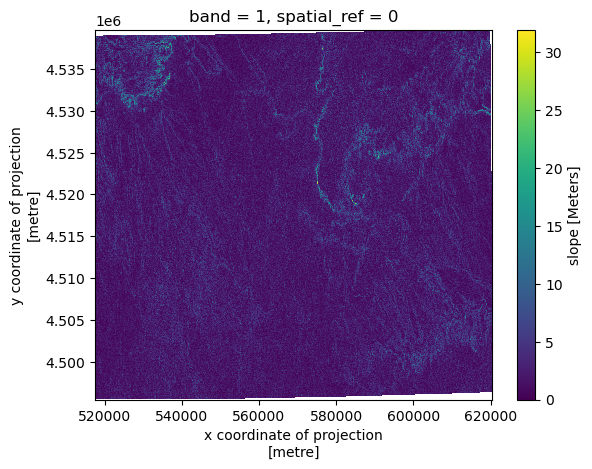

In [12]:
pawnee_slope_da.plot()

In [13]:
# # https://lpdaac.usgs.gov/products/srtmgl1v003/
# # https://appeears.earthdatacloud.nasa.gov/api/#temporary-s3-credentials
# # https://appeears.earthdatacloud.nasa.gov/products
# # https://lpdaac.usgs.gov/resources/e-learning/getting-started-with-the-a%CF%81%CF%81eears-api-submitting-and-downloading-an-area-request/

# def get_elev_data(input_gdf, data_directory):
#     data_dir = data_directory

#     # Download Elevation Data Using Appeears
#     elevation_downloader = etapp.AppeearsDownloader(
#         download_key="SRTM_DEM",
#         ea_dir=data_dir,
#         product="SRTMGL1_NC.003",
#         layer="SRTMGL1_DEM",
#         start_date="02-11-2020",
#         end_date="02-21-2020",
#         polygon=input_gdf,
#     )

#     # Download files if the download directory does not exist
#     if not os.path.exists(elevation_downloader.data_dir):
#         elevation_downloader.download_files()

# get_elev_data(comanche_grassland_gdf, data_dir)


In [22]:
def download_maca2_data(data_directory, model, scenario, variable_abb, st_year, end_year):
    """
    Attributes
    ----------
    data_directory: path
        The path to the data directory where the MACA2 data will be 
        stored

    model: string
        Represents the selected MACA2 model that data will be downloaded 
        for. Acceptable values are: 'bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M'.

    scenario: string
        Represents the climate scenario that data will be downloaded for.
        Must be 'rcp45', 'rcp85', or 'historical'.

    variable_abb: string
        The abbreviation for the climate variable that data will be 
        downloaded for. Acceptable values are: tasmax', 'tasmin', 
        'rhsmax', 'rhsmin', 'pr', 'rsds', 'uas', 'vas', 'huss'.

    st_year: integer
        A four-digit integer representing the start year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.

    end_year: integer
        A four-digit integer representing the end year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.
    
    Returns
    ----------
    clim_da: xarray.Dataset
        Returns a dataset containing the downloaded MACA2 data

    """
    model_lst = ['bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M']
    
    if model not in model_lst:
        raise ValueError("The listed model {0} is not valid."
                         "Check input".format(model)
                         )

    variables_long_list = ['precipitation', 'air_temperature', 
                      'air_temperature', 'relative_humidity',
                      'relative_humidity', 
                      'surface_downwelling_shortwave_flux_in_air',
                      'eastward_wind', 
                      'northward_wind',
                      'specific_humidity'
    ]

    variables_abb_lst = ['pr', 'tasmax', 'tasmin', 'rhsmin', 'rhsmax', 
                      'rsds', 'uas', 'vas', 'huss']
    
    if variable_abb not in variables_abb_lst:
        raise ValueError("The listed variable abbreviation {0} is not "
                        "valid. Check value".format(variable_abb)
                         )

    # Dictionary to get variable long name
    variables_dict = {variables_abb_lst[i]: variables_long_list[i] 
           for i in range(len(variables_long_list))}

    # Create template for MACA url path
    template_url = ("http://thredds.northwestknowledge.net:8080"\
                "/thredds/ncss/agg_macav2metdata_{0}_{1}_r"\
                "{2}i1p1_{3}_{4}_CONUS_monthly.nc"\
                "?var={5}"\
                "&disableLLSubset=on"
                "&disableProjSubset=on"
                "&horizStride=1&time_start={6}-01-15T00%3A00%3A00Z"
                "&time_end={7}-12-15T00%3A00%3A00Z"
                "&timeStride=1"
                "&accept=netcdf"
    )

    # Define whether url value is r6i1p1 or r1i1p1
    if model == "CCSM4":
        value = 6
    else:
        value = 1
    
    # Define year range for scenario
    if scenario == "historical":
        year_range = "1950_2005"
    else:
        year_range = "2006_2099"
    
    # Create url for download
    url = template_url.format(variable_abb,
                              model,
                              value,
                              scenario,
                              year_range,
                              variables_dict.get(variable_abb),
                              st_year,
                              end_year
                              )

    # Make request to url
    maca_response = requests.get(url)

    # Create template for MACA2 file name
    template_filename = ("{0}_{1}_{2}_{3}to{4}.nc"
    )

    # Generate file name for saving
    file_path = os.path.join(data_directory, template_filename.format(model,
                                        scenario,
                                        variable_abb,
                                        st_year,
                                        end_year
                                        )
    )
    
    if not os.path.exists(file_path):
        # Save data
        with open(file_path, 'wb') as maca_file:
            maca_file.write(maca_response.content)
        print("Downloading data")
    
    else:
        print("A MACA2 file for this scenario is already saved in the "
              "directory. Skipping download.")

    # Open the dataset    
    clim_dataset = xr.open_dataset(file_path)

    return clim_dataset

CCSM4_rcp45_da = download_maca2_data(data_dir, "CCSM4", "rcp45", "pr", 2040, 2040)
    
CCSM4_rcp85_da = download_maca2_data(data_dir, "CCSM4", "rcp85", "pr", 2040, 2040)

A MACA2 file for this scenario is already saved in the directory. Skipping download.
A MACA2 file for this scenario is already saved in the directory. Skipping download.


In [24]:
# Assign coords & set spatial dimensions
def maca2_assign_coords(xr_dataset):
    # Get data variable name from xr_dataset
    var_name = list(xr_dataset.keys())[0]
    # Assign coordinates
    xr_dataset = xr_dataset.assign_coords(lon =  xr_dataset.lon - 360, inplace=True)
    # Select data
    out_da = xr_dataset[var_name]
    out_da.rio.write_crs("epsg:4326", inplace=True)
    out_da.rio.set_spatial_dims('lon','lat',inplace=True)
    return out_da

CCSM4_rcp45_da = maca2_assign_coords(CCSM4_rcp45_da)
CCSM4_rcp85_da = maca2_assign_coords(CCSM4_rcp85_da)

In [27]:
CCSM4_rcp85_da.mean('time').hvplot()

:Image   [lon,lat]   (precipitation)

In [28]:
CCSM4_rcp45_da.mean('time').hvplot()

:Image   [lon,lat]   (precipitation)

In [16]:
# CCSM4_rcp85_da.rio.reproject(utm).rio.clip_box(*comanche_grassland_gdf.to_crs("epsg:4326").total_bounds).rio.reproject_match(comanche_pH_da)


In [29]:
comanche_CCSM4_rcp45_da = clip_and_reproj_match(CCSM4_rcp45_da, 
                                                select_grassland_gdf.loc[['Comanche National Grassland']],
                                                comanche_pH_da)

comanche_CCSM4_rcp85_da = clip_and_reproj_match(CCSM4_rcp85_da, 
                                                select_grassland_gdf.loc[['Comanche National Grassland']],
                                                comanche_pH_da)

pawnee_CCSM4_rcp45_da = clip_and_reproj_match(CCSM4_rcp45_da, 
                                                select_grassland_gdf.loc[['Pawnee National Grassland']],
                                                pawnee_pH_da)

pawnee_CCSM4_rcp85_da = clip_and_reproj_match(CCSM4_rcp85_da, 
                                                select_grassland_gdf.loc[['Pawnee National Grassland']],
                                                pawnee_pH_da)

In [48]:
CCSM4_rcp45_da.mean('time').hvplot()

SyntaxError: invalid syntax (1013988619.py, line 1)

In [ ]:
CCSM4_rcp85_da.mean('time').hvplot()

# Model

In [21]:
pawnee_rcp85 = ((pawnee_pH_da < 8) * (pawnee_pH_da > 4.8) * 
        (pawnee_CCSM4_rcp85_da.mean('time') < 45) * 
        (pawnee_CCSM4_rcp85_da.mean('time') > 11)).hvplot(rasterize=True)

os.chdir("/workspaces/")
hvplot.save(pawnee_rcp85, 'pawnee_rcp85.html')

In [ ]:

pawnee_rcp45 = ((pawnee_pH_da < 8) * (pawnee_pH_da > 4.8) * 
        (pawnee_CCSM4_rcp45_da.mean('time') < 45) * 
        (pawnee_CCSM4_rcp45_da.mean('time') > 11)).hvplot(rasterize=True)

os.chdir("/workspaces/")
hvplot.save(pawnee_rcp45, 'pawnee_rcp45.html')